In [49]:
# numpy and torch
import numpy as np
import torch

#SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

#Scipy ODE solver
from scipy.integrate import solve_ivp

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

In [50]:
# Constantes
torch.manual_seed(0)
tf = 50 # Cambiar
dt = 0.001
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

In [51]:
# NFBL params
k1, k2, k3, k4, Ac, As, xi= 1, 2, 0.05, 0.05, 1, 1, 0 # Cambiar

def system(t, z, k1, k2, k3, k4, Ac, As, xi):
    """
    This function returns the ODE system.

    Args:
        t (float): time (optional)
        z (list): state variables
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        As (float): As constant
        xi (float): xi constant
    
    Returns:
        list: ODE system
    """
    x, y = z
    return [- k1*x - k2*y + Ac + As, k3*x - k4*y + xi*Ac + xi*As]

def simulator(k1, k2, k3, k4, Ac, As, xi):
    """Solves the ODE system using the SciPy solver.

    Args:
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        As (float): As constant
        xi (float): xi constant

    Returns:
        The solution of the ODE system.
    """
    return solve_ivp(system, tspan, c0, args = (k1, k2, k3, k4, Ac, As, xi), t_eval = t) # Paso explicito

In [52]:
sim = simulator(k1, k2, k3, k4, Ac, As, xi)
# print(sim)

In [53]:
# true parameters and respective labels
true_params = np.array([k1, k2, k3, k4, Ac, As, xi])
labels_params = [r"$k_{1}$", r"$k_{2}$", r"$k_{3}$", r"$k_{4}$", r"$A_{c}$", r"$A_{s}$", r"$\xi$"]

observation_trace = simulator(true_params[0], true_params[1], true_params[2], true_params[3], true_params[4], true_params[5], true_params[6])

def calculate_summary_statistics(x):
    """Calculates the summary statistics (attributes) of the system.

    Args:
        x (array): The system state variable.

    Returns:
        A numpy array with the summary statistics of the system (Xpeak, Tpeak, x50, t50, x_ss, t_ss)
    """
    
    # Similar a Jonah, pero con algunas diferencias
    dt = 0.001 # Setear, quizas como parametro?
    
    # Peak
    Xpeak = np.max(x)
    Tpeak = np.where(x == Xpeak)[0][0] * dt

    # Steady state
    # Get X steady state using diff
    # diff_x = np.abs(np.diff(x))   
    # tol = 1e-8
    # x_ss = np.where(diff_x < tol)[0] 
    # if x_ss.size > 0:
    #     x_ss = x_ss[x_ss >= Tpeak/dt] # We need to avoid the peak
    #     x_ss = x[x_ss[0]]
    # else:
    #     x_ss = x[-1]
    
    tol = 1e-4
    x_ss = x[-1] # ASUMIMOS que en el tiempo final llega al steady state
    
    # We need to calculate the time of the steady state, 
    # this needs to be the first time the system reaches the steady state after the peak
    peak_index = np.argmax(x)
    
    # t_ss has to be the first x after peak_index that is equal to x_ss +/- tol
    t_ss = np.where(np.abs(x[peak_index:] - x_ss) < tol)[0][0] * dt
    
    # Punto medio entre Xpeak y SS
    x50 = (Xpeak - x_ss)/2 + x_ss
    t50 = np.where(x >= x50)[-1][-1] * dt

    # Debugging
    # print(Xpeak)
    # print(Tpeak)
    # print(x50)
    # print(t50)
    # print(id_ss)
    # print(t_ss)
    # print(np.array([Xpeak, Tpeak, x50, t50, id_ss, t_ss]))

    # Jonah tambien usa Skew y Kurtosis, es otra posibilidad
    return np.array([Xpeak, Tpeak, x50, t50, x_ss, t_ss])

observation_summary_statistics = calculate_summary_statistics(observation_trace.y[0]) #y[0] = x, y[1] = y

[ 1.67761752  2.72        1.1720101   8.02        0.66640268 45.992     ]


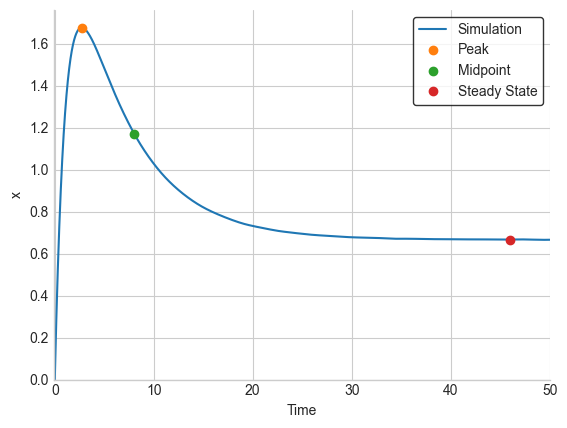

In [54]:
k1, k2, k3, k4, Ac, As, xi= 1, 2, 0.05, 0.05, 1, 1, 0

# Plot ODE +  Stats
sol = simulator(k1, k2, k3, k4, Ac, As, xi)
plt.plot(sol.t, sol.y[0], label="Simulation")

stats = calculate_summary_statistics(sol.y[0])
print(stats)

plt.plot(stats[1], stats[0], 'o', label="Peak", markersize=6) #tpeak es en x, xpeak es en y
plt.plot(stats[3], stats[2], 'o', label="Midpoint", markersize=6)
plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)
plt.ylim(0, stats[0]*1.05)
plt.plot(stats[5], stats[4], 'o', label="Steady State", markersize=6)
plt.legend(frameon=True, facecolor="white", edgecolor="black")
plt.show()


In [55]:
# Pregunta: Queremos pasarle estadisticas (simulation wrapper) o el output de la simulacion (simulator) (es decir, que busque
# el exact trace) a la red neuronal?
def simulation_wrapper(params):
    """
    Returns summary statistics from the model results using `params`.

    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    obs = simulator(params[0], params[1], params[2], params[3], params[4], params[5], params[6]).y[0] #y[0] = x
    stats = torch.as_tensor(calculate_summary_statistics(obs))
    return stats

In [56]:
print(simulation_wrapper([0, 1, 0, 0, 0, 1, 1]))

tensor([ 5.0000e-01,  1.0000e+00, -5.9973e+02,  3.5647e+01, -1.2000e+03,
         4.8999e+01], dtype=torch.float64)


In [57]:
num_dim = 7; # Cantidad de inputs

#prior_min = []
#prior_max = []
#prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
prior = utils.BoxUniform(low = 0*torch.ones(num_dim), high = 2*torch.ones(num_dim))

# A infer hay que pasarle el wrapper del simulator, no el simulator
posterior = infer(simulation_wrapper, prior, method="SNPE", num_simulations=10000, num_workers=1) #paralellizable

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 222 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

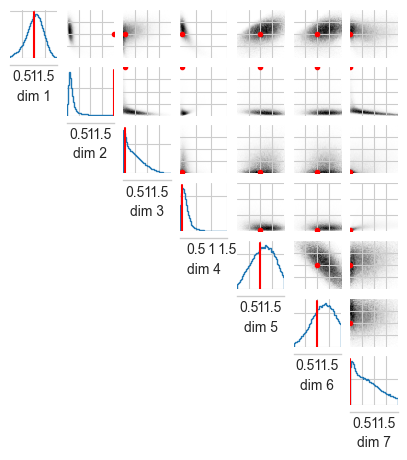

In [58]:
samples = posterior.sample((100000,), x=observation_summary_statistics)

fig, axes = analysis.pairplot(
    samples,
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[1.238031   0.15266548 0.5289902  0.1485369  1.3992593  1.1239189
  0.5586456 ]]


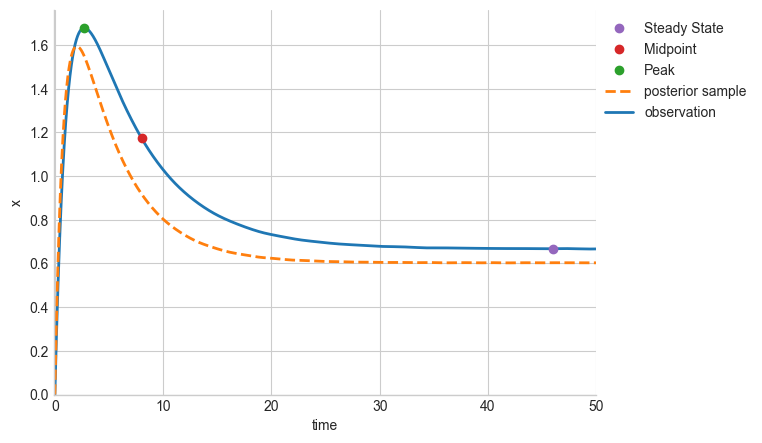

In [88]:
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()
fig = plt.figure(figsize=(7, 5))

# plot observation
t = observation_trace.t
y_obs = observation_trace.y[0]
plt.plot(t, y_obs, lw=2, label="observation")
print(posterior_sample)

# simulate and plot samples from the posterior
x = simulator(posterior_sample[0][0], posterior_sample[0][1], posterior_sample[0][2], posterior_sample[0][3], posterior_sample[0][4], posterior_sample[0][5], posterior_sample[0][6])
plt.plot(x.t, x.y[0], "--", lw=2, label="posterior sample")

plt.plot(stats[1], stats[0], 'o', label="Peak", markersize=6) #tpeak es en x, xpeak es en y
plt.plot(stats[3], stats[2], 'o', label="Midpoint", markersize=6)
plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)
plt.ylim(0, stats[0]*1.05)
plt.plot(stats[5], stats[4], 'o', label="Steady State", markersize=6)
plt.legend(frameon=True, facecolor="white", edgecolor="black")

plt.xlabel("time")
plt.ylabel("x")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")